<a href="https://colab.research.google.com/github/victor-roris/mediumseries/blob/master/NLP/NLPModel_MultiLabel_SVM_Count%26TFIDFVectorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Model with Linear Support Vector Machine 

In this notebook, we are going to use a Linear Support Vector Machine Model to predict categories of text. Linear Support Vector Machine is widely regarded as one of the best text classification algorithms. To vectorize the text we are going to use the combination of CountVector (multi-hot array) and TFIDF approach.

Support Vector Machines: https://scikit-learn.org/stable/modules/svm.html#svm

Sklearn CountVectorizer: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

Sklearn TFIDF: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

Notebook adapted from: https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568



In [0]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline

## Data

### Fetch data

We are using a relatively large data set of Stack Overflow questions and tags.

In [2]:
df = pd.read_csv('https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv')
df = df[pd.notnull(df['tags'])]
categories = df["tags"].unique()

print(f'Number of examples : {len(df)}')
print(f'Number of words in the data: {df["post"].apply(lambda x: len(x.split(" "))).sum()}')
print(f'Number of categorie : {len(categories)}')
print()
print(df.head(10))
print()
print(f'Categories: {categories}')


Number of examples : 40000
Number of words in the data: 10286120
Number of categorie : 20

                                                post           tags
0  what is causing this behavior  in our c# datet...             c#
1  have dynamic html load as if it was in an ifra...        asp.net
2  how to convert a float value in to min:sec  i ...    objective-c
3  .net framework 4 redistributable  just wonderi...           .net
4  trying to calculate and print the mean and its...         python
5  how to give alias name for my website  i have ...        asp.net
6  window.open() returns null in angularjs  it wo...      angularjs
7  identifying server timeout quickly in iphone  ...         iphone
8  unknown method key  error in rails 2.3.8 unit ...  ruby-on-rails
9  from the include  how to show and hide the con...      angularjs

Categories: ['c#' 'asp.net' 'objective-c' '.net' 'python' 'angularjs' 'iphone'
 'ruby-on-rails' 'ios' 'c' 'sql' 'java' 'jquery' 'css' 'c++' 'php'
 'android' 'my

Visualize data

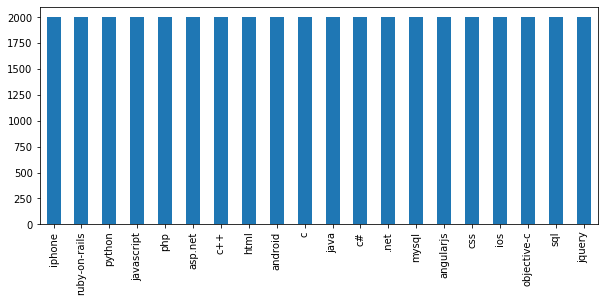

In [3]:
plt.figure(figsize=(10,4))
df.tags.value_counts().plot(kind='bar');

The classes are very well balanced.

### Text pre-processing

Our text cleaning step includes HTML decoding, remove stop words, change text to lower case, remove punctuation, remove bad characters, and so on.

In [4]:
 nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    

print(f'Example text previous cleaning : {df["post"].values[10]}')

df['post'] = df['post'].apply(clean_text)

print(f'Example text previous cleaning : {df["post"].values[10]}')

Example text previous cleaning : when we need interface c# <blockquote>    <strong>possible duplicate:</strong><br>   <a href= https://stackoverflow.com/questions/240152/why-would-i-want-to-use-interfaces >why would i want to use interfaces </a>   <a href= https://stackoverflow.com/questions/9451868/why-i-need-interface >why i need interface </a>    </blockquote>     i want to know where and when to use it     for example    <pre><code>interface idemo {  // function prototype  public void show(); }  // first class using the interface class myclass1 : idemo {  public void show()  {   // function body comes here   response.write( i m in myclass );  }  }  // second class using the interface class myclass2 : idemo {  public void show()   {   // function body comes here   response.write( i m in myclass2 );   response.write( so  what  );  } </code></pre>   these two classes has the same function name with different body. this can be even achieved without interface. then why we need an interf

In [6]:
print(f'Number of words in the cleaning data: {df["post"].apply(lambda x: len(x.split(" "))).sum()}')

Number of words in the cleaning data: 3424297


### Prepare data

In [0]:
X = df.post
y = df.tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

## Model training

To train the model we will convert our text documents to a matrix of token counts (CountVectorizer), then transform the count matrix to a normalized tf-idf representation (tf-idf transformer). 

In [0]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])

We train the vectorizers and model

In [9]:
%%time
sgd.fit(X_train, y_train)

CPU times: user 3.54 s, sys: 929 ms, total: 4.46 s
Wall time: 3.48 s


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                ('clf',
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                      

## Model evaluation

In [10]:
%%time
from sklearn.metrics import classification_report
y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=categories))

accuracy 0.7895833333333333
               precision    recall  f1-score   support

           c#       0.73      0.67      0.70       613
      asp.net       0.84      0.94      0.89       620
  objective-c       0.88      0.95      0.92       587
         .net       0.81      0.80      0.80       586
       python       0.73      0.89      0.80       599
    angularjs       0.77      0.39      0.52       589
       iphone       0.81      0.69      0.74       594
ruby-on-rails       0.71      0.95      0.81       610
          ios       0.83      0.57      0.67       617
            c       0.72      0.58      0.64       587
          sql       0.71      0.65      0.68       611
         java       0.79      0.88      0.83       594
       jquery       0.77      0.79      0.78       619
          css       0.84      0.86      0.85       574
          c++       0.82      0.81      0.81       584
          php       0.70      0.68      0.69       578
      android       0.81      0.90  